In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Load the dataset
data = pd.read_csv("TeleCom_Data-1.csv", sep=';', header=0)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41180 entries, 0 to 41179
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                        Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                        --------------  ----- 
 0   age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"  41180 non-null  object
dtypes: object(1)
memory usage: 321.8+ KB


In [3]:
data

,"age;""job"";""marital"";""education"";""default"";""housing"";""loan"";""contact"";""month"";""day_of_week"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""emp.var.rate"";""cons.price.idx"";""cons.conf.idx"";""euribor3m"";""nr.employed"";""y"""
0,"40;""admin."";""married"";""basic.6y"";""no"";""no"";""no..."
1,"56;""services"";""married"";""high.school"";""no"";""no..."
2,"45;""services"";""married"";""basic.9y"";""unknown"";""..."
3,"59;""admin."";""married"";""professional.course"";""n..."
4,"41;""blue-collar"";""married"";""unknown"";""unknown""..."
...,...
41175,"29;""unemployed"";""single"";""basic.4y"";""no"";""yes""..."
41176,"73;""retired"";""married"";""professional.course"";""..."
41177,"46;""blue-collar"";""married"";""professional.cours..."
41178,"56;""retired"";""married"";""university.degree"";""no..."


In [4]:
data[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month',
    'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = data['age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"'].str.split(';', expand=True)

# Drop the original combined column
data.drop('age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"', axis=1, inplace=True)

In [5]:
data = data.applymap(lambda x: x.replace('"', '') if isinstance(x, str) else x)

In [6]:
# Map "yes" to 1 and "no" to 0 in the 'responsiveness' column
data['y'] = data['y'].str.replace('"', '').apply(lambda x: 1 if x == "yes" else 0)

In [7]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:

# Descriptive statistics
data.describe()

,y
count,41180.000000
mean,0.112627
std,0.316141
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
unique_marital_values = data['marital'].unique()
count_of_each_value = data['marital'].value_counts()

print("Number of unique values in 'marital':", len(unique_marital_values))
print("\nCount of each unique value:")
print(count_of_each_value)

Number of unique values in 'marital': 4

Count of each unique value:
married     24921
single      11568
divorced     4611
unknown        80
Name: marital, dtype: int64


In [10]:
# Step 1: Replace 'yes' with 1 and 'no' with 0
data = data.replace({'yes': 1, 'no': 0})

# Step 2: Identify and drop rows with "rubbish" values (e.g., 'unknown')
data = data[data != 'unknown'].dropna()

# Reset the index of the DataFrame after dropping rows
data = data.reset_index(drop=True)

In [11]:
label_encoder = LabelEncoder()

# Apply label encoding to the 'marital' column
data['marital'] = label_encoder.fit_transform(data['marital'])
print(data['marital'])

0        1
1        1
2        1
3        2
4        2
        ..
30476    2
30477    1
30478    1
30479    1
30480    1
Name: marital, Length: 30481, dtype: int64


In [12]:
# Create dictionaries to map month names to numerical values and day of the week to numerical values
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

day_of_week_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5
}

# Apply the mappings to the respective columns
data['month'] = data['month'].str.lower().map(month_mapping)
data['day_of_week'] = data['day_of_week'].str.lower().map(day_of_week_mapping)
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,40,admin.,1,basic.6y,0,0,0,telephone,5,1,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
1,56,services,1,high.school,0,0,1,telephone,5,1,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
2,59,admin.,1,professional.course,0,0,0,telephone,5,1,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
3,24,technician,2,professional.course,0,1,0,telephone,5,1,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
4,25,services,2,high.school,0,1,0,telephone,5,1,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30476,29,unemployed,2,basic.4y,0,1,0,cellular,11,5,...,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,0
30477,73,retired,1,professional.course,0,1,0,cellular,11,5,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
30478,46,blue-collar,1,professional.course,0,0,0,cellular,11,5,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
30479,56,retired,1,university.degree,0,1,0,cellular,11,5,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [13]:
# Define a list of columns to be converted to float
columns_to_convert = ['age', 'marital', 'default', 'housing', 'loan', 'month', 'day_of_week', 'y']

# Initialize LabelEncoders for each column and convert them to float
label_encoders = {}
for column in columns_to_convert:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# If you need to reverse the encoding to get the original values later, you can use label_encoders like this:
# original_values = label_encoders['column_name'].inverse_transform(data['column_name'])


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30481 entries, 0 to 30480
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30481 non-null  int64 
 1   job             30481 non-null  object
 2   marital         30481 non-null  int64 
 3   education       30481 non-null  object
 4   default         30481 non-null  int64 
 5   housing         30481 non-null  int64 
 6   loan            30481 non-null  int64 
 7   contact         30481 non-null  object
 8   month           30481 non-null  int64 
 9   day_of_week     30481 non-null  int64 
 10  duration        30481 non-null  object
 11  campaign        30481 non-null  object
 12  pdays           30481 non-null  object
 13  previous        30481 non-null  object
 14  poutcome        30481 non-null  object
 15  emp.var.rate    30481 non-null  object
 16  cons.price.idx  30481 non-null  object
 17  cons.conf.idx   30481 non-null  object
 18  euribo

### Data cleaning ends here

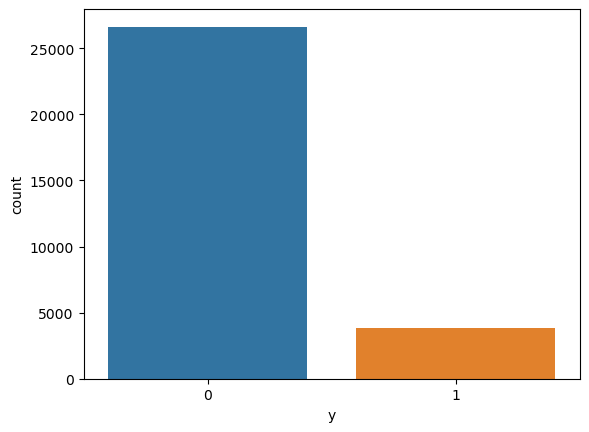

In [15]:
# Data visualization
sns.countplot(x='y', data=data)
plt.show()

In [16]:
# Preprocessing: Encode categorical variables, standardize numeric variables, etc.

# Model Building
# Split the dataset into features and target variable
X = data.drop('y', axis=1)
y = data['y']

In [17]:
# Encode categorical variables
label_encoder = LabelEncoder()
X['job'] = label_encoder.fit_transform(X['job'])
# Repeat this for other categorical variables

In [18]:

# Select columns with numerical or float data types
numerical_columns = data.select_dtypes(include=[np.number, 'float64'])

# Create a new dataset with only numerical or float columns
new_data = data[numerical_columns.columns]

# Let's display the first few rows of the new dataset
new_data.head()

,age,marital,default,housing,loan,month,day_of_week,y
0,23,1,0,0,0,5,0,0
1,39,1,0,0,1,5,0,0
2,42,1,0,0,0,5,0,0
3,7,2,0,1,0,5,0,0
4,8,2,0,1,0,5,0,0


## EDA Start

In [19]:
numerical_columns = ['age', 'marital', 'default', 'housing', 'loan', 'month', 'day_of_week', 'y']
numerical_data = data[numerical_columns]

# Summary Statistics
summary_stats = numerical_data.describe()


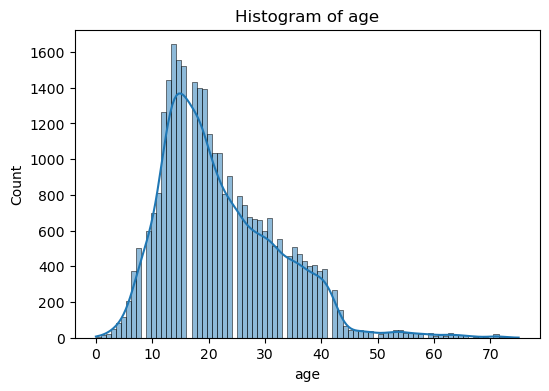

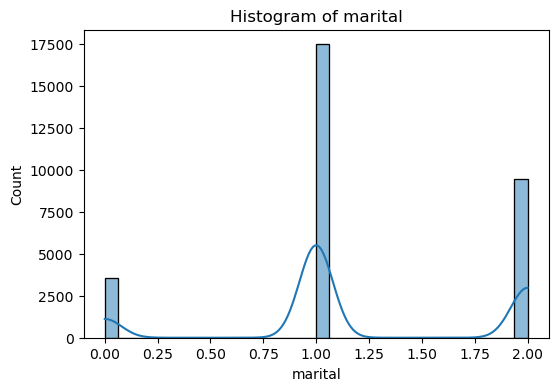

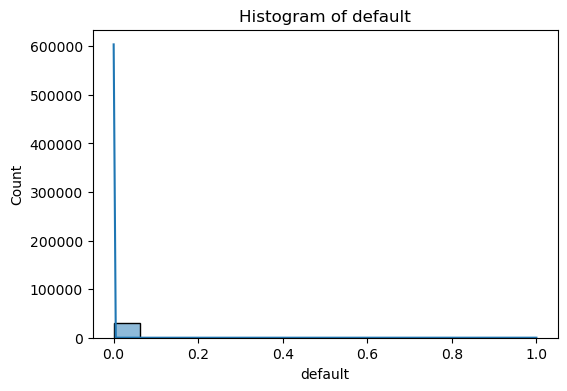

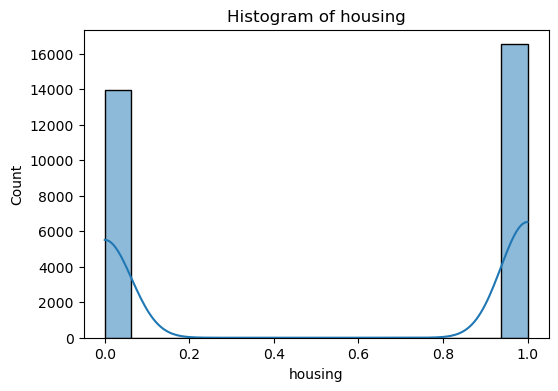

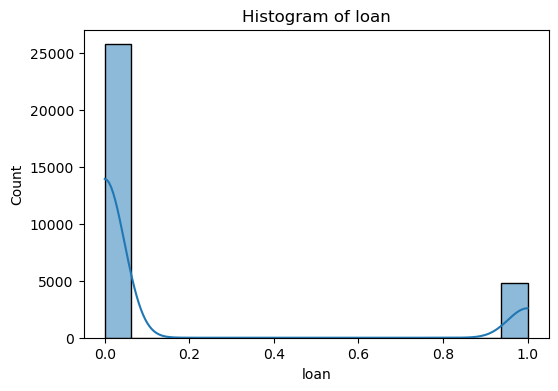

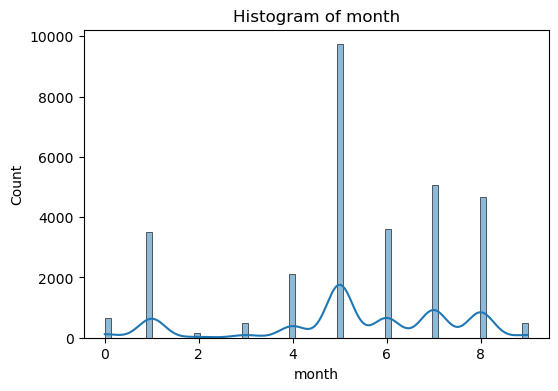

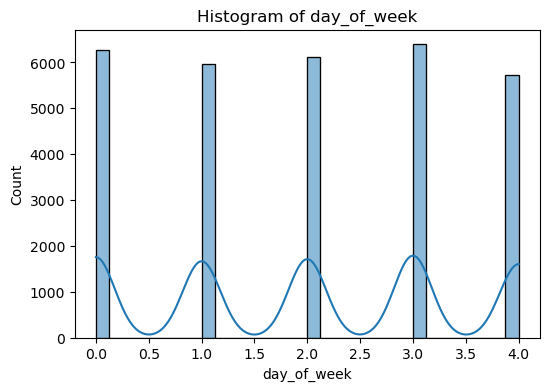

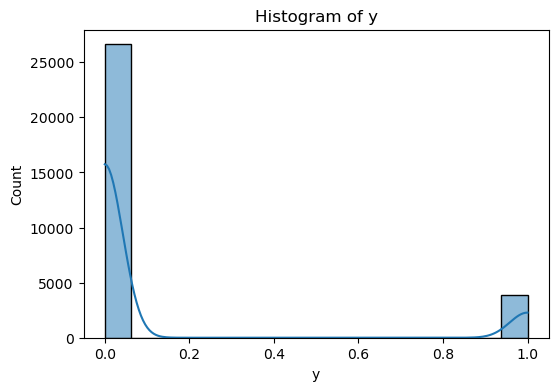

In [20]:
# Histograms for numerical columns
for column in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()


Text(0.5, 1.0, 'Correlation Matrix')

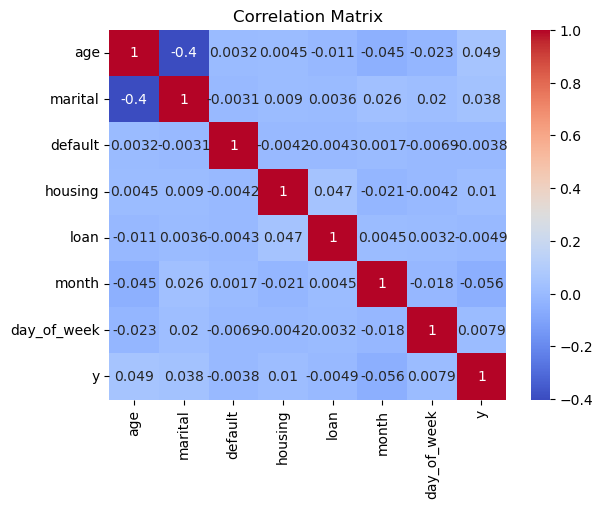

In [21]:
# Correlation Analysis
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [22]:
# Categorical Columns EDA
categorical_columns = ['job', 'education', 'contact', 'poutcome']
categorical_data = data[categorical_columns]

# Frequency Counts
for column in categorical_columns:
    value_counts = data[column].value_counts()
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for job:
admin.           8737
blue-collar      5674
technician       5472
services         2856
management       2310
retired          1214
self-employed    1092
entrepreneur     1089
unemployed        738
housemaid         689
student           610
Name: job, dtype: int64

Value counts for education:
university.degree      10410
high.school             7698
professional.course     4319
basic.9y                4275
basic.4y                2379
basic.6y                1389
illiterate                11
Name: education, dtype: int64

Value counts for contact:
cellular     20439
telephone    10042
Name: contact, dtype: int64

Value counts for poutcome:
nonexistent    25833
failure         3459
success         1189
Name: poutcome, dtype: int64



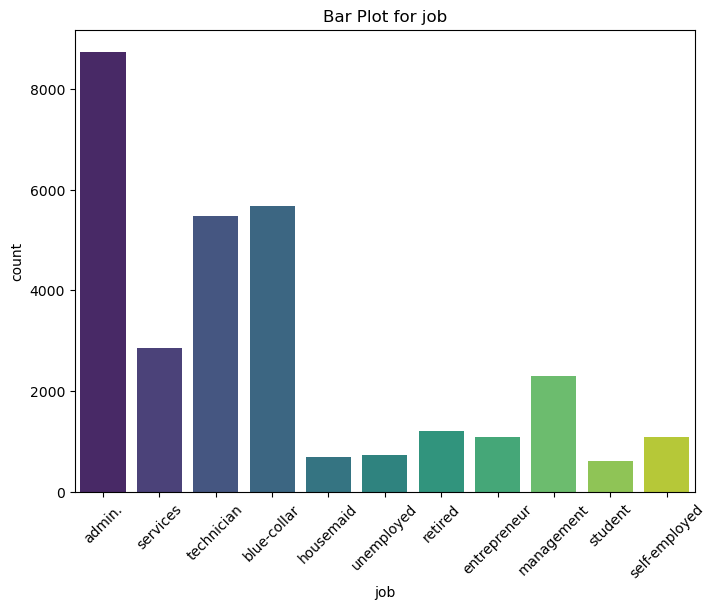

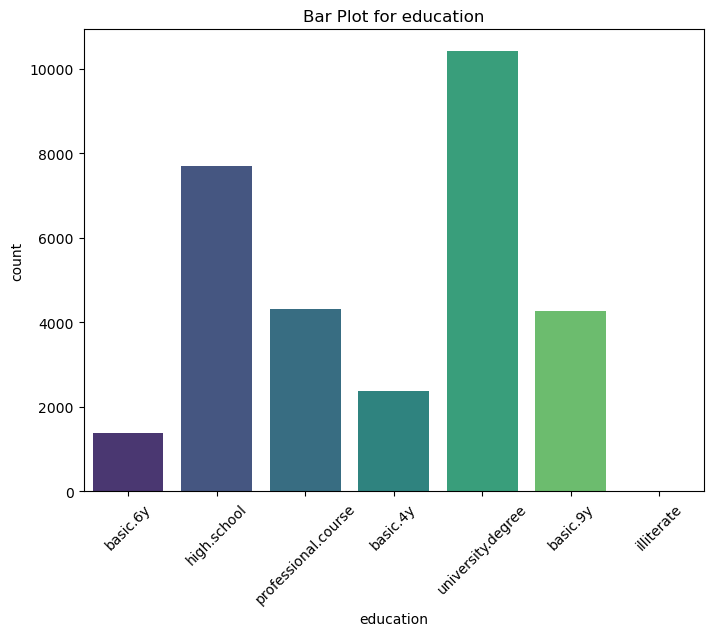

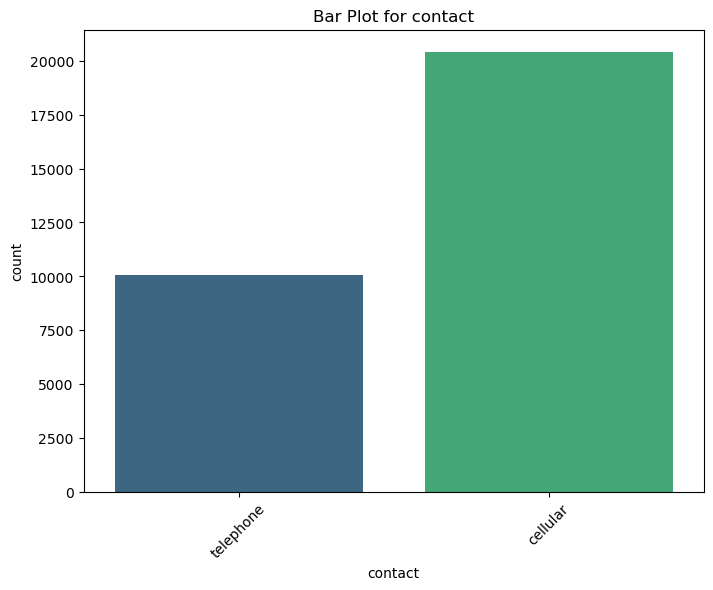

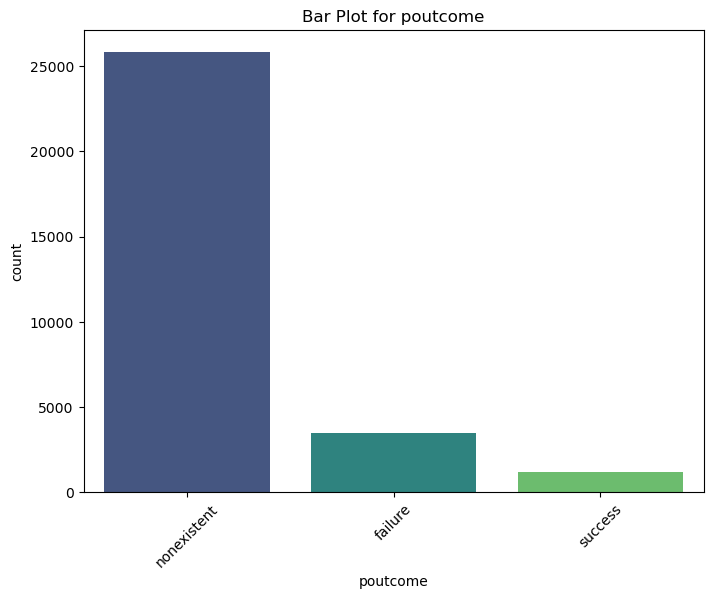

In [23]:
# Bar Plots
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=data, palette='viridis')
    plt.title(f'Bar Plot for {column}')
    plt.xticks(rotation=45)
    plt.show()

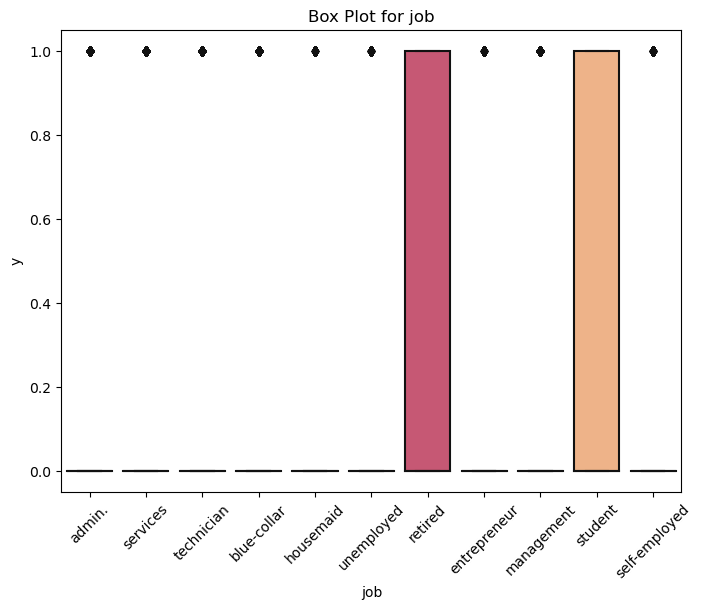

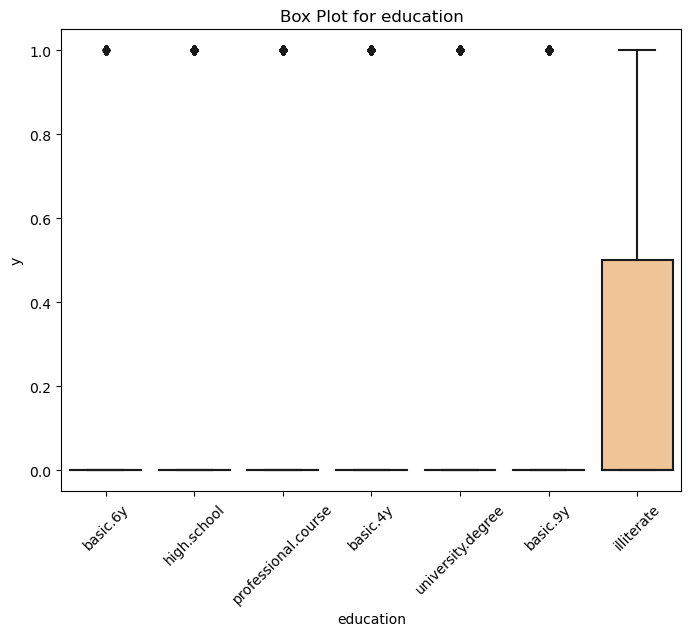

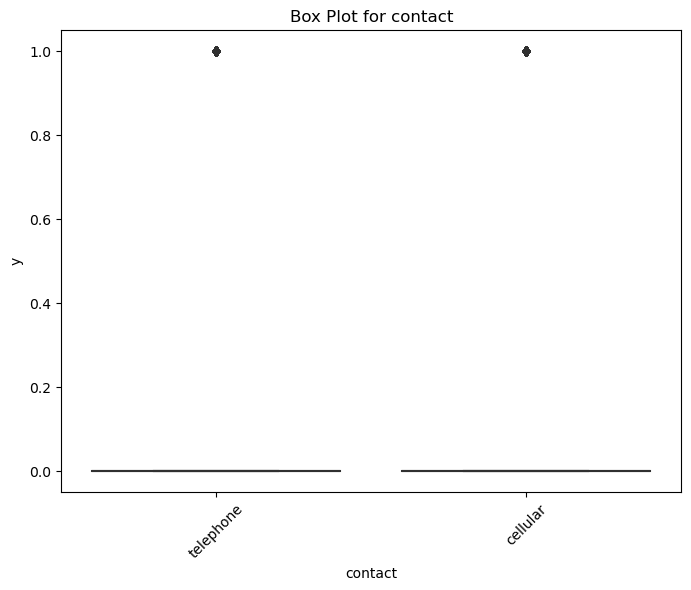

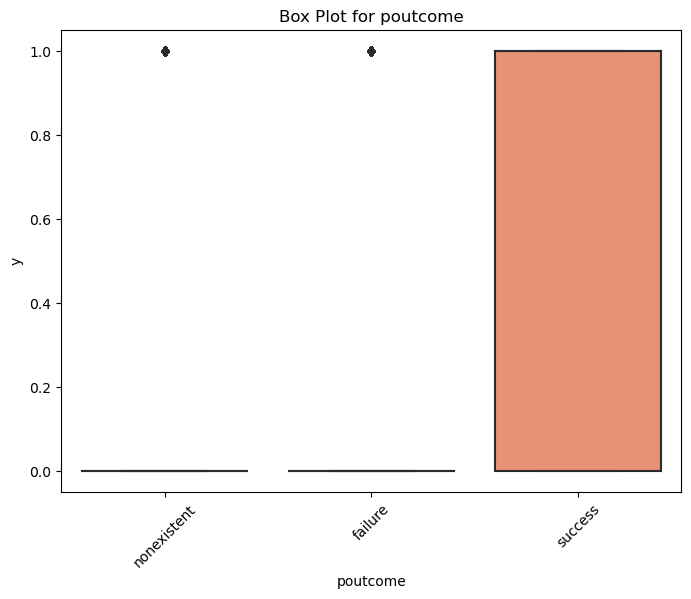

In [24]:
# Box Plots (for outlier detection)
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=column, y='y', data=data, palette='magma')
    plt.title(f'Box Plot for {column}')
    plt.xticks(rotation=45)
    plt.show()

In [25]:
# Cross-tabulation (for examining relationships between two categorical variables)
cross_tab = pd.crosstab(data['marital'], data['y'])
print("Cross-tabulation between marital and y:\n", cross_tab)

Cross-tabulation between marital and y:
 y            0     1
marital             
0         3142   410
1        15432  2054
2         8050  1393


**1. Histograms:**
   - A histogram is used to visualize the distribution of a single numerical variable, such as 'age' or 'duration.'
   - The x-axis represents the range of values, and the y-axis represents the frequency (or count) of observations within each bin.
   - A smooth line (kernel density estimate or KDE) may be overlaid to provide an estimate of the probability density function.
   - Interpretation:
     - The shape of the histogram can reveal the underlying distribution, such as normal, skewed, or bimodal.
     - It helps identify patterns, central tendencies, and possible outliers.

**2. Correlation Matrix Heatmap:**
   - A heatmap is used to display the correlation matrix between numerical variables, showing the strength and direction of the linear relationships between variables.
   - Colors indicate the strength and direction of correlation (e.g., positive correlations in one color, negative in another).
   - Interpretation:
     - Positive values indicate a positive correlation, while negative values suggest a negative correlation.
     - Values close to 1 or -1 indicate strong correlations, while values close to 0 suggest weak or no correlation.
     - Useful for identifying relationships between variables that might be valuable for predictive modeling.

**3. Bar Plots:**
   - Bar plots are used to visualize the distribution of categorical variables, such as 'job,' 'education,' 'contact,' and 'poutcome.'
   - The x-axis represents the unique categories, and the y-axis represents the count or frequency of each category.
   - Interpretation:
     - It shows the prevalence of different categories in a categorical variable.
     - Useful for identifying imbalances in the distribution and identifying predominant categories.

**4. Box Plots:**
   - Box plots are used to identify the presence of outliers and visualize the distribution of a numerical variable across different categories.
   - The box represents the interquartile range (IQR), and the whiskers extend to the minimum and maximum values within a specified range.
   - Points outside the whiskers are considered outliers.
   - Interpretation:
     - Outliers can be detected as individual points beyond the whiskers.
     - It provides a summary of the distribution, showing median, quartiles, and range for each category.

**5. Cross-Tabulation:**
   - Cross-tabulation is used to examine the relationship between two categorical variables. It creates a contingency table.
   - Rows represent one categorical variable, and columns represent the other, showing the counts or percentages in each combination.
   - Interpretation:
     - It helps in understanding how two categorical variables are related to each other.
     - Useful for identifying patterns and associations between variables.

These visualizations and analyses collectively helps in gaining insights into the data, such as identifying data distributions, relationships between variables, and the presence of outliers or patterns in the dataset. They are crucial for making informed decisions when preparing the data for machine learning or statistical analysis.

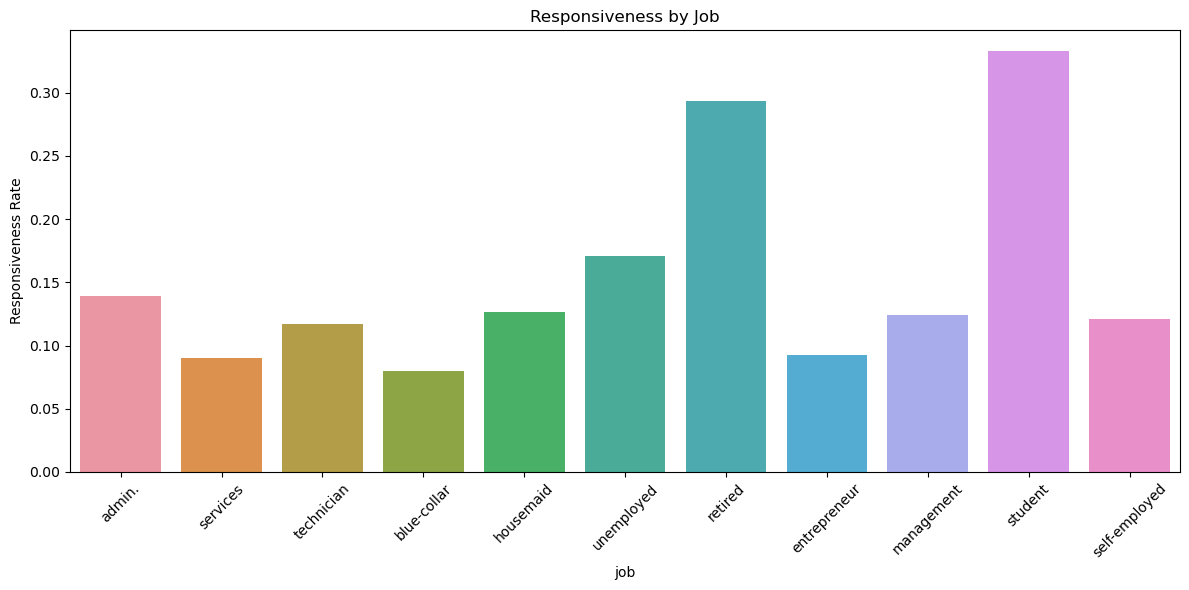

In [26]:
# Analyze the subscription rate based on different customer characteristics
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='job', y='y', errorbar=None, estimator=np.mean)
plt.xticks(rotation=45)
plt.title('Responsiveness by Job')
plt.ylabel('Responsiveness Rate')
plt.tight_layout()
plt.show()

The graph depicts how various customer job types respond to the marketing campaign. Each bar represents a job category, with its height indicating the average responsiveness rate within that category.

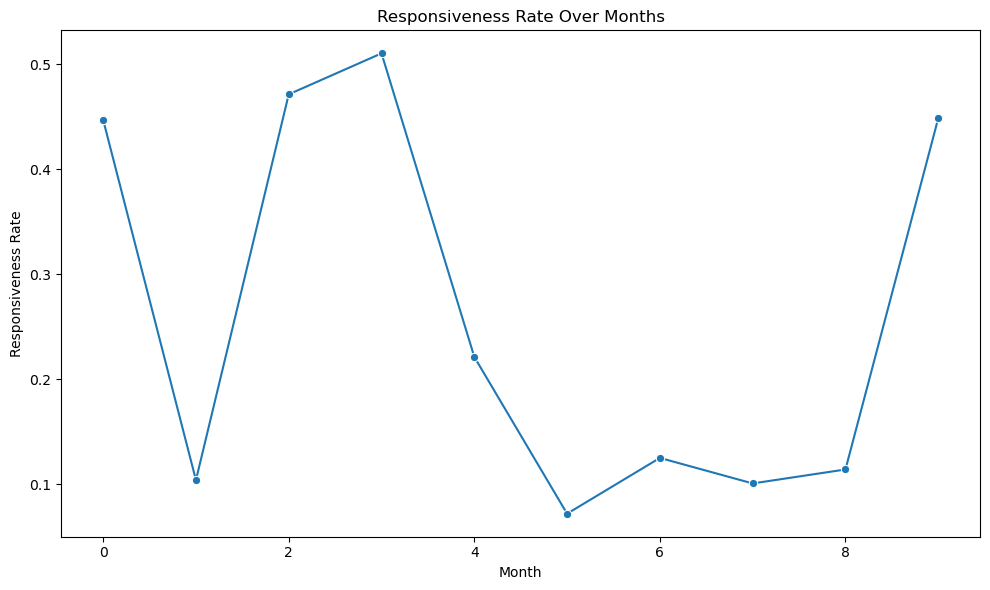

In [27]:
# Calculate responsiveness rate over months
responsiveness_by_month = data.groupby('month')['y'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=responsiveness_by_month, marker='o')
plt.title('Responsiveness Rate Over Months')
plt.ylabel('Responsiveness Rate')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

The graph depicts monthly responsiveness rates with marked averages, showcasing trends for informed marketing strategy decisions.

## New feature creation

1. Feature 1: account_balance: We can derive this by considering variables like whether a person has a default (default), a housing loan (housing), and a personal loan (loan). We'll assign a score based on these. If a person has none of them, the account balance is 'high', if they have 1, it's 'medium', and if they have 2 or more, it's 'low'.
2. Feature 2: contact_duration: Convert duration from seconds to minutes for ease of understanding and categorize it into 'short', 'medium', and 'long'.

In [28]:
# Feature 1: account_balance
data['account_balance'] = data['default'] + data['housing'] + data['loan']
data['account_balance'] = data['account_balance'].map({0: 'high', 1: 'medium', 2: 'low', 3: 'low'})

# Feature 2: contact_duration
data['duration'] = data['duration'].astype(float)
data['contact_duration'] = pd.cut(data['duration']/60, bins=[0, 5, 15, np.inf], labels=['short', 'medium', 'long'])

# Let's see the head of the dataset after feature creation
print(data[['account_balance', 'contact_duration']].head())

  account_balance contact_duration
0            high            short
1          medium           medium
2            high            short
3          medium           medium
4          medium            short


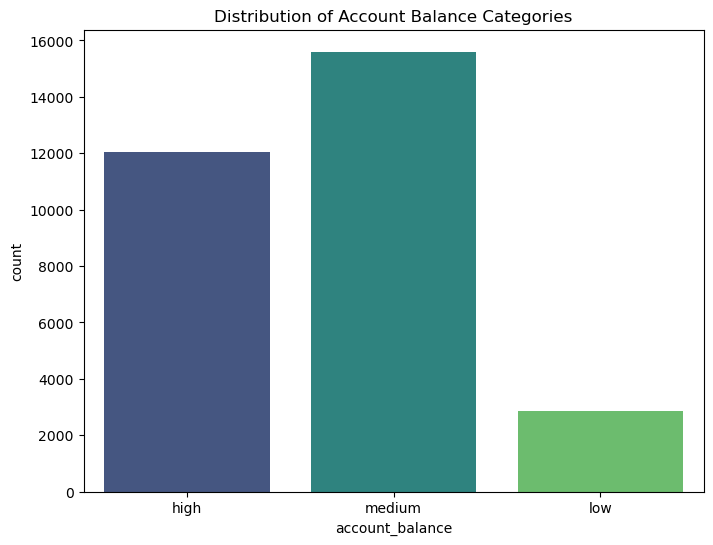

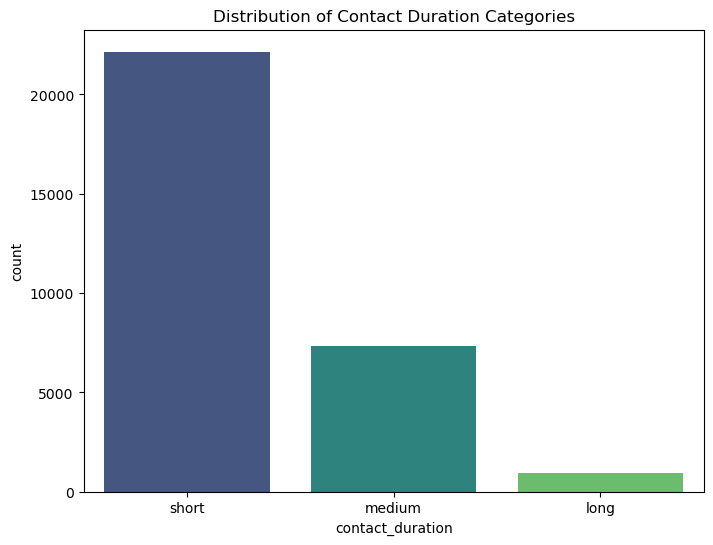

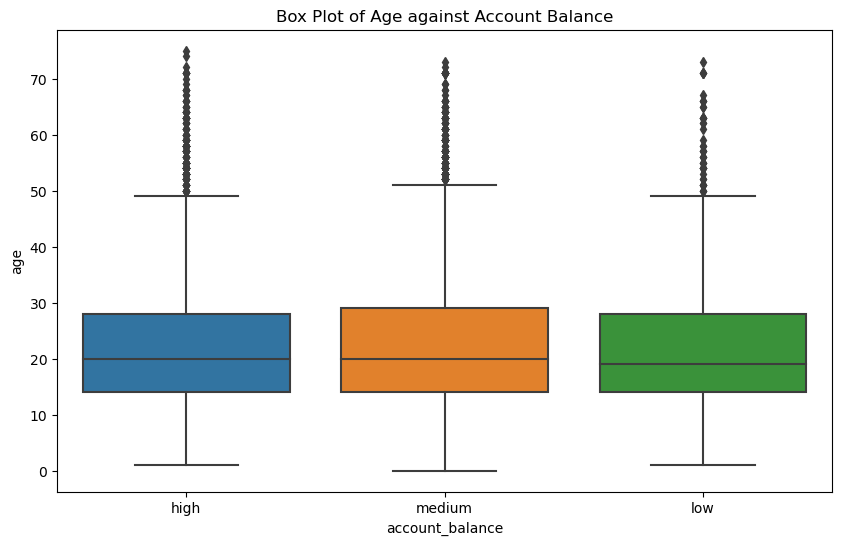

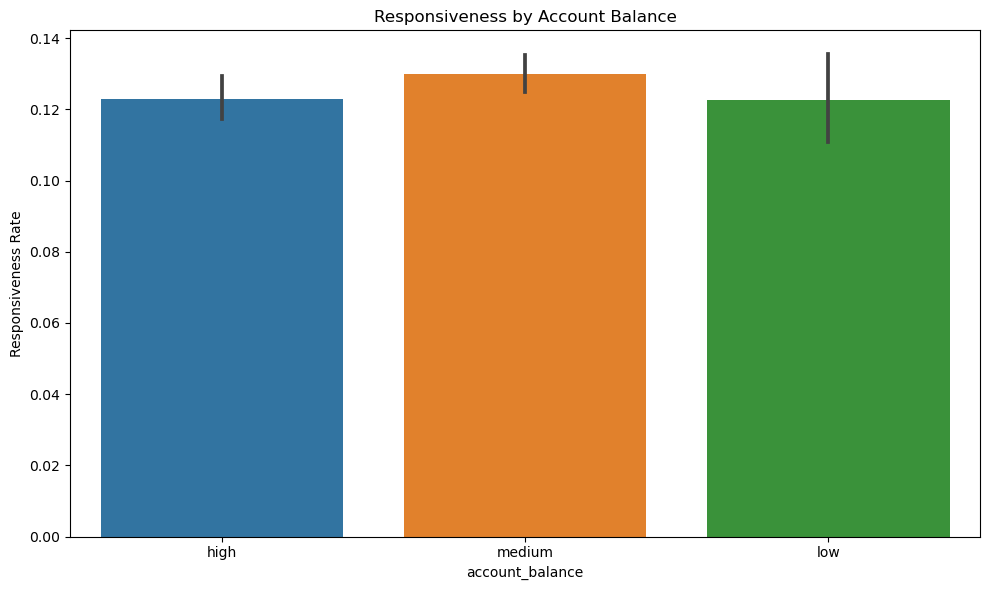

In [29]:
# Bar Plot for account_balance
plt.figure(figsize=(8, 6))
sns.countplot(x='account_balance', data=data, order=['high', 'medium', 'low'], palette='viridis')
plt.title('Distribution of Account Balance Categories')
plt.show()

# Interpretation:
# This graph will give you an understanding of how many customers fall under each account balance category.

# Bar Plot for contact_duration
plt.figure(figsize=(8, 6))
sns.countplot(x='contact_duration', data=data, order=['short', 'medium', 'long'], palette='viridis')
plt.title('Distribution of Contact Duration Categories')
plt.show()

# Interpretation:
# This graph will help in understanding the duration of the majority of contacts with customers.

# Boxplot of age against account_balance to see if age has any influence on account_balance
plt.figure(figsize=(10, 6))
sns.boxplot(x='account_balance', y='age', data=data, order=['high', 'medium', 'low'])
plt.title('Box Plot of Age against Account Balance')
plt.show()

# Interpretation:
# This graph will show if different age groups have different account balance categories predominantly.

# Responsiveness by account_balance
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='account_balance', y='y', order=['high', 'medium', 'low'])
plt.title('Responsiveness by Account Balance')
plt.ylabel('Responsiveness Rate')
plt.tight_layout()
plt.show()

# Interpretation:
# This graph will help in understanding if the responsiveness varies by the account balance category.

This gives a clear idea of how the newly created features are distributed, their relationship with age, and how they might be influencing the responsiveness.

In [30]:
# Perform one-hot encoding for 'account_balance'
data = pd.get_dummies(data, columns=['account_balance'], prefix='account_balance')

In [31]:
# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])


In [32]:
print(data.dtypes)
for column in data.columns:
    if data[column].dtype == 'object':
        print(f"Unique values in {column}:\n{data[column].unique()}\n")


age                          int64
job                          int64
marital                      int64
education                    int64
default                      int64
housing                      int64
loan                         int64
contact                      int64
month                        int64
day_of_week                  int64
duration                   float64
campaign                    object
pdays                       object
previous                    object
poutcome                     int64
emp.var.rate                object
cons.price.idx              object
cons.conf.idx               object
euribor3m                   object
nr.employed                 object
y                            int64
contact_duration          category
account_balance_high         uint8
account_balance_low          uint8
account_balance_medium       uint8
dtype: object
Unique values in campaign:
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '12' '11' '18' '23' '14' '22'
 '25' '17' '

In [33]:
# Select columns with numerical or float data types
numerical_columns = data.select_dtypes(include=[np.number, 'float64'])

# Create a new dataset with only numerical or float columns
new_data = data[numerical_columns.columns]

# Let's display the first few rows of the new dataset
new_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,poutcome,y,account_balance_high,account_balance_low,account_balance_medium
0,23,0,1,1,0,0,0,1,5,0,151.0,1,0,1,0,0
1,39,7,1,3,0,0,1,1,5,0,307.0,1,0,0,0,1
2,42,0,1,5,0,0,0,1,5,0,139.0,1,0,1,0,0
3,7,9,2,5,0,1,0,1,5,0,380.0,1,0,0,0,1
4,8,7,2,3,0,1,0,1,5,0,50.0,1,0,0,0,1


## Model Building

In [34]:

# Split the dataset into features and target variable
X = new_data.drop('y', axis=1)
y = new_data['y']


In [35]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:

# Standardize numerical variables
scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=[int, float])
X_train[numeric_columns.columns] = scaler.fit_transform(numeric_columns)
X_test[numeric_columns.columns] = scaler.transform(X_test[numeric_columns.columns])


In [37]:

# Model Building
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}


In [38]:

# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': confusion
    }


/Users/hemang/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hemang/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hemang/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:

# Display model evaluation results
for model_name, metrics in results.items():
    print(f"Model: {model_name}\n")
    print(f"Accuracy: {metrics['Accuracy']:.2f}\n")
    print(f"Classification Report:\n{metrics['Classification Report']}\n")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

Model: Logistic Regression

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5297
           1       0.63      0.20      0.31       800

    accuracy                           0.88      6097
   macro avg       0.76      0.59      0.62      6097
weighted avg       0.86      0.88      0.85      6097


Confusion Matrix:
[[5202   95]
 [ 637  163]]

Model: Random Forest

Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5297
           1       0.65      0.39      0.49       800

    accuracy                           0.89      6097
   macro avg       0.78      0.68      0.71      6097
weighted avg       0.88      0.89      0.88      6097


Confusion Matrix:
[[5128  169]
 [ 489  311]]

Model: K-Nearest Neighbors

Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

  

## Hyperparameter Tuning for Random Forest

In [40]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf_model = RandomForestClassifier()

# Create a GridSearchCV object with the model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


## Model Evaluation

In [41]:
# Create a Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_split=best_params['min_samples_split'],
                                       min_samples_leaf=best_params['min_samples_leaf'])

# Train the model
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Display the evaluation metrics
print("Model Evaluation with Best Hyperparameters:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Model Evaluation with Best Hyperparameters:
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      5297
           1       0.67      0.38      0.48       800

    accuracy                           0.89      6097
   macro avg       0.79      0.67      0.71      6097
weighted avg       0.88      0.89      0.88      6097

Confusion Matrix:
 [[5146  151]
 [ 498  302]]


# Insights

## Insight 1: Feature Importance

Random Forest models, for example, can provide feature importance scores that indicate the influence of different variables on the prediction of campaign success. You can extract and analyze these feature importance scores to understand which customer characteristics or attributes are most important in determining campaign success. For example:

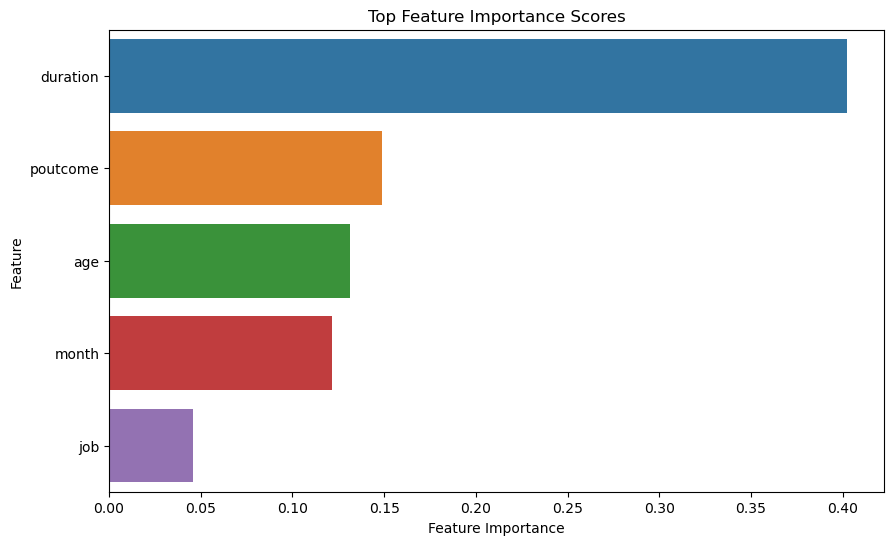

In [42]:
# After training the Random Forest model with best hyperparameters
feature_importance = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Extract the top N most important features
top_n = 5
top_features = X_train.columns[sorted_indices][:top_n]

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[sorted_indices][:top_n], y=top_features)
plt.title('Top Feature Importance Scores')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

This analysis will provide insights into the customer characteristics that have the most significant impact on campaign success, allowing the company to focus its marketing efforts on these attributes.

## Insight 2: Responsiveness by Month

As shown in your code, you have already analyzed the responsiveness rate over months. Continue this analysis to identify which months have the highest and lowest responsiveness rates. This information can help the company plan its marketing campaigns more effectively, such as concentrating efforts during high-responsive months.

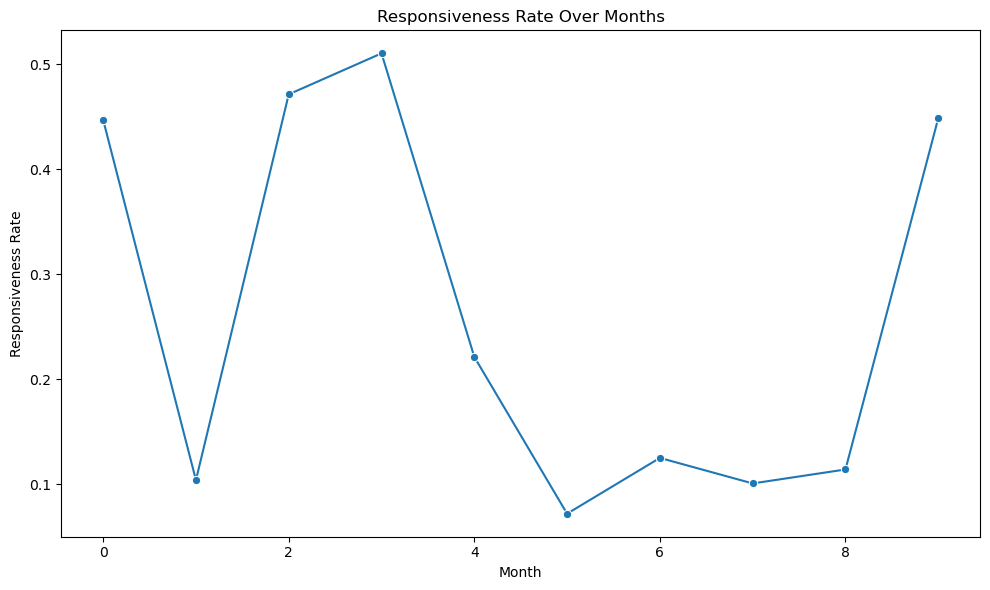

In [43]:
# Plot the responsiveness rate over months
plt.figure(figsize=(10, 6))
sns.lineplot(data=responsiveness_by_month, marker='o')
plt.title('Responsiveness Rate Over Months')
plt.ylabel('Responsiveness Rate')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

By identifying patterns in responsiveness rates over different months, the company can optimize the timing of its marketing campaigns.

## Insight 3: Account Balance and Campaign Success

You have created a new feature, 'account_balance,' which categorizes customers based on their account balance. Analyze how this feature relates to campaign success. For example, you can visualize the campaign success rates for customers with high, medium, and low account balances.

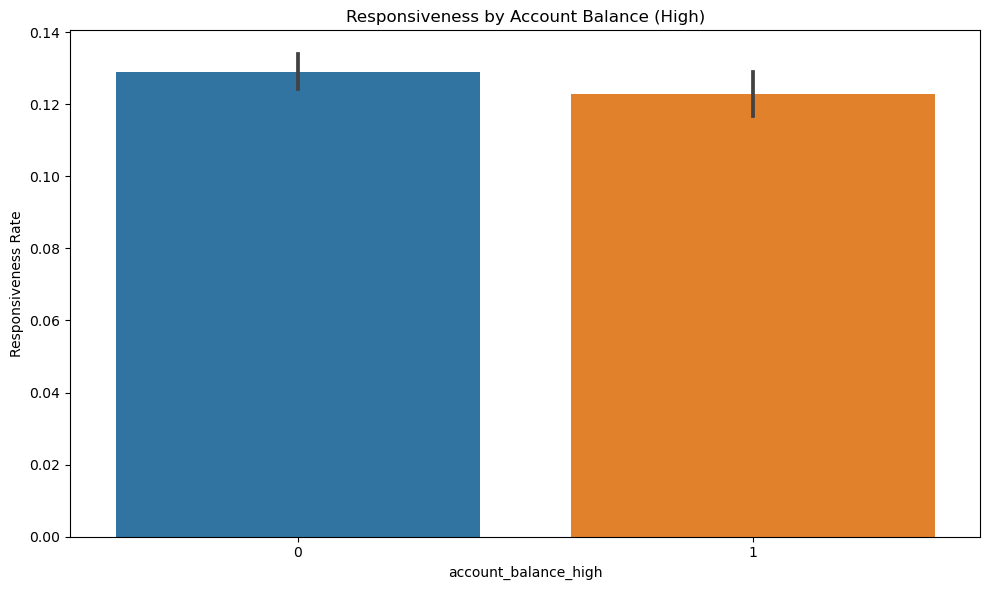

Cross-tabulation between Account Balance (High) and Campaign Success:
 y                         0     1
account_balance_high             
0                     16066  2377
1                     10558  1480


In [44]:
# Responsiveness by account_balance categories
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='account_balance_high', y='y')
plt.title('Responsiveness by Account Balance (High)')
plt.ylabel('Responsiveness Rate')
plt.tight_layout()
plt.show()

# Cross-tabulation between account_balance_high and campaign success
cross_tab_high = pd.crosstab(data['account_balance_high'], data['y'])
print("Cross-tabulation between Account Balance (High) and Campaign Success:\n", cross_tab_high)

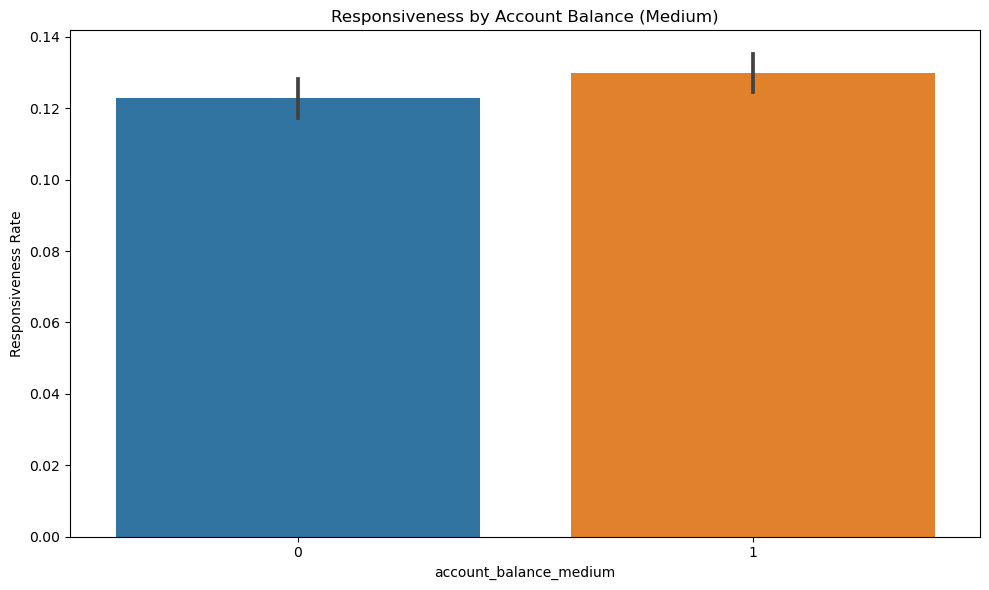

Cross-tabulation between Account Balance (Medium) and Campaign Success:
 y                           0     1
account_balance_medium             
0                       13052  1829
1                       13572  2028


In [45]:
# Responsiveness by account_balance categories
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='account_balance_medium', y='y')
plt.title('Responsiveness by Account Balance (Medium)')
plt.ylabel('Responsiveness Rate')
plt.tight_layout()
plt.show()

# Cross-tabulation between account_balance_medium and campaign success
cross_tab_high = pd.crosstab(data['account_balance_medium'], data['y'])
print("Cross-tabulation between Account Balance (Medium) and Campaign Success:\n", cross_tab_high)

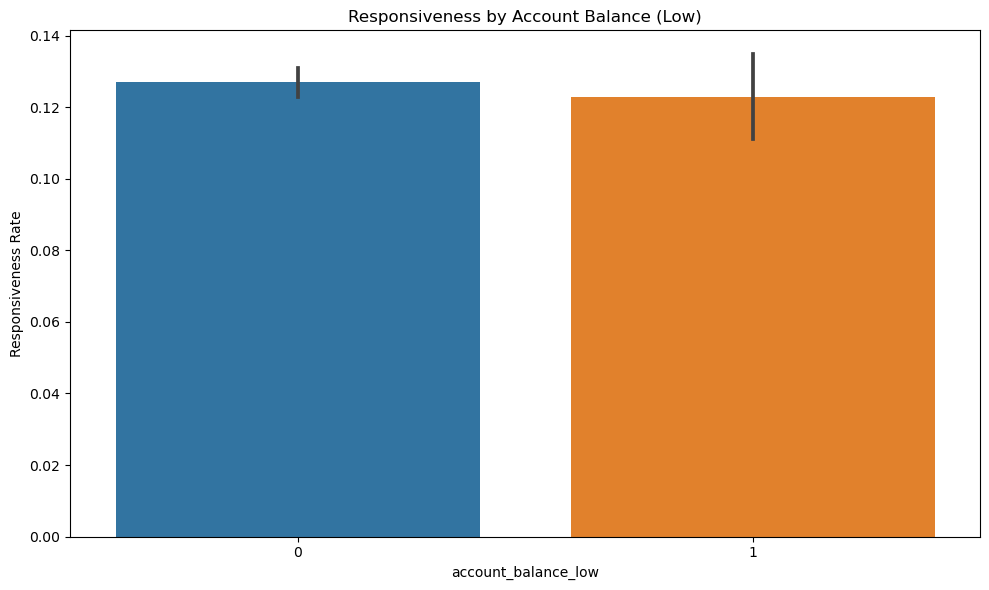

Cross-tabulation between Account Balance (Low) and Campaign Success:
 y                        0     1
account_balance_low             
0                    24130  3508
1                     2494   349


In [46]:
# Responsiveness by account_balance categories
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='account_balance_low', y='y')
plt.title('Responsiveness by Account Balance (Low)')
plt.ylabel('Responsiveness Rate')
plt.tight_layout()
plt.show()

# Cross-tabulation between account_balance_high and campaign success
cross_tab_high = pd.crosstab(data['account_balance_low'], data['y'])
print("Cross-tabulation between Account Balance (Low) and Campaign Success:\n", cross_tab_high)